# MURA-Densenet-v1.7-Humerus


In [ ]:
!pip install focal-loss
!pip install keras-radam

In [2]:
import os
import numpy as np
import cv2
import random
import pandas as pd
from tqdm import tqdm
import keras.backend as K
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras.preprocessing.image import ImageDataGenerator, load_img#, image
from keras import regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.applications.densenet import DenseNet169, DenseNet121, preprocess_input
from time import time


from focal_loss import BinaryFocalLoss
from keras_radam import RAdam

import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip '/content/drive/My Drive/Dataset/MURA-v1.1.zip' 

In [5]:
def listdir_nohidden(path):
    '''
    Utility function to find the list of files in a directory excluding the hidden files.
    Args:
        path: contains the path of the directory containing the images

    '''
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [6]:
def create_images_metadata_csv(category,study_types):
    '''
    This function creates a csv file containing the path of images, label.
    Args:
        category: train or valid, depending on which csv is needed
        study_types: the type of the body part in MURA Dataset, eg:  XR_SHOULDER
    '''
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    #study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    #study_types = ['XR_ELBOW']
    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = 'MURA-v1.1/%s/%s/' % (category, study_type)
        patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(list(listdir_nohidden(path)))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path,1, label]  # add new row
                        i += 1
    image_data[category].to_csv(category+"_image_data.csv",index = None, header=False)

In [7]:
def getImageLabels(dataframe):
  '''
  This function is to get the labels of the images from the dataframe
  Args:
      dataframe: pandas dataframe containing the labels of the images

  '''
  labels = []
  for i, data in tqdm(dataframe.iterrows()):
#        img = cv2.imread(data['Path'])
#         #random rotation
#         angle = random.randint(-30,30)
#         M = cv2.getRotationMatrix2D((img_width/2,img_height/2),angle,1)
#         img = cv2.warpAffine(img,M,(img_width,img_height))
      #resize
#        img = cv2.resize(img,(img_width,img_height))    
#        img = img[...,::-1].astype(np.float32)
#        images.append(img)
      labels.append(data['Label'])
#    images = np.asarray(images).astype('float32') 
  #normalization
#    mean = np.mean(images[:, :, :])
#    std = np.std(images[:, :, :])
#    images[:, :, :] = (images[:, :, :] - mean) / std
  labels = np.asarray(labels)
  return labels

In [8]:
def getImage(dataframe, size):
    '''
    Function to process the images
    Args:
        dataframe: contains the path to the images in the directory
        size: contains the value to which the shape of the image will resized
    '''
    Images = []
    for i, data in tqdm(dataframe.iterrows()):
      try:
        image = cv2.imread(data['Path'])#cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(size,size))
        #image = randome_rotation_flip(image,size)
        Images.append(image)

      except Exception as e:
        print(str(e))

    Images = np.asarray(Images).astype('float32')

    mean = np.mean(Images)			#normalization
    std = np.std(Images)
    Images = (Images - mean) / std
    
    #if K.image_data_format() == "channels_first":
    #  Images = np.expand_dims(Images,axis=3)		   #Extended dimension 1
    #if K.image_data_format() == "channels_last":
    #  Images = np.expand_dims(Images,axis=3)             #Extended dimension 3(usebackend tensorflow:aixs=3; theano:axixs=1) 
    return Images


In [9]:
def build_model():
    base_model = DenseNet169(input_shape=(None, None,3),
                             weights='imagenet',
                             include_top=False,
                             pooling='avg')


    x = base_model.output

    predictions = Dense(n_classes,activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

### Data Preprocessing

In [10]:
###################
# Data processing #
###################

img_width, img_height = 224, 224
#Keras ImageDataGenerator to load, transform the images of the dataset

IMG_DATA_DIR = 'MURA-v1.1/'
train_data_dir = IMG_DATA_DIR + 'train/XR_HUMERUS'
valid_data_dir = IMG_DATA_DIR + 'valid/XR_HUMERUS'

train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)
study_types = ['XR_HUMERUS']

#TRAIN DATA
create_images_metadata_csv('train',study_types)
#VALID DATA
create_images_metadata_csv('valid',study_types)

100%|██████████| 132/132 [00:00<00:00, 174.79it/s]


In [11]:
valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])
train_image_df = pd.read_csv('train_image_data.csv', names=['Path', 'Count','Label'])

dd={}

dd['train'] = train_image_df
dd['valid'] = valid_image_df

In [12]:
train_image_labels = getImageLabels(train_image_df)

1272it [00:00, 14185.88it/s]


In [13]:
train_images = getImage(train_image_df, size = 224)

1272it [00:04, 275.51it/s]


In [ ]:
train_images.shape


(1272, 224, 224, 3)

In [14]:
train_datagen.fit(train_images,augment=True)

In [15]:
train_generator = train_datagen.flow(
    x=train_images,
    y=train_image_labels,
    batch_size = 32
)

In [16]:
valid_image_labels = getImageLabels(valid_image_df)

288it [00:00, 12859.12it/s]


In [17]:
valid_images = getImage(valid_image_df, size = 224)

288it [00:01, 238.97it/s]


In [18]:
test_datagen.fit(valid_images,augment=True)

In [19]:
validation_generator = test_datagen.flow(
    x=valid_images,
    y=valid_image_labels,
    batch_size = 1
)

### Recontructed Model

In [20]:
from keras.models import load_model
#reconstructed_model = load_model('MURA-DenseNet-v1.7-Humerus.h5')
reconstructed_model = load_model('/content/drive/My Drive/Models/MURA-DenseNet-v1.7-Humerus.h5') 

In [21]:
nb_validation_samples = len(valid_images)
ev = reconstructed_model.evaluate(validation_generator, steps=nb_validation_samples,  workers=0, use_multiprocessing=False)
ev[1]

288/288 [==============================] - 44s 27ms/step - loss: 0.1080 - acc: 0.8368 - mse: 0.1420


0.8368055820465088

In [22]:
validation_generator.reset()
pred_batch = reconstructed_model.predict_on_batch(valid_images)

In [23]:
predictions = []
for p in pred_batch:
    if(p > 0.5):
        predictions+=[1]
    else:
        predictions+=[0]

In [24]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]  
pred = predictions

### Confusion Matric

Confusion Matrix


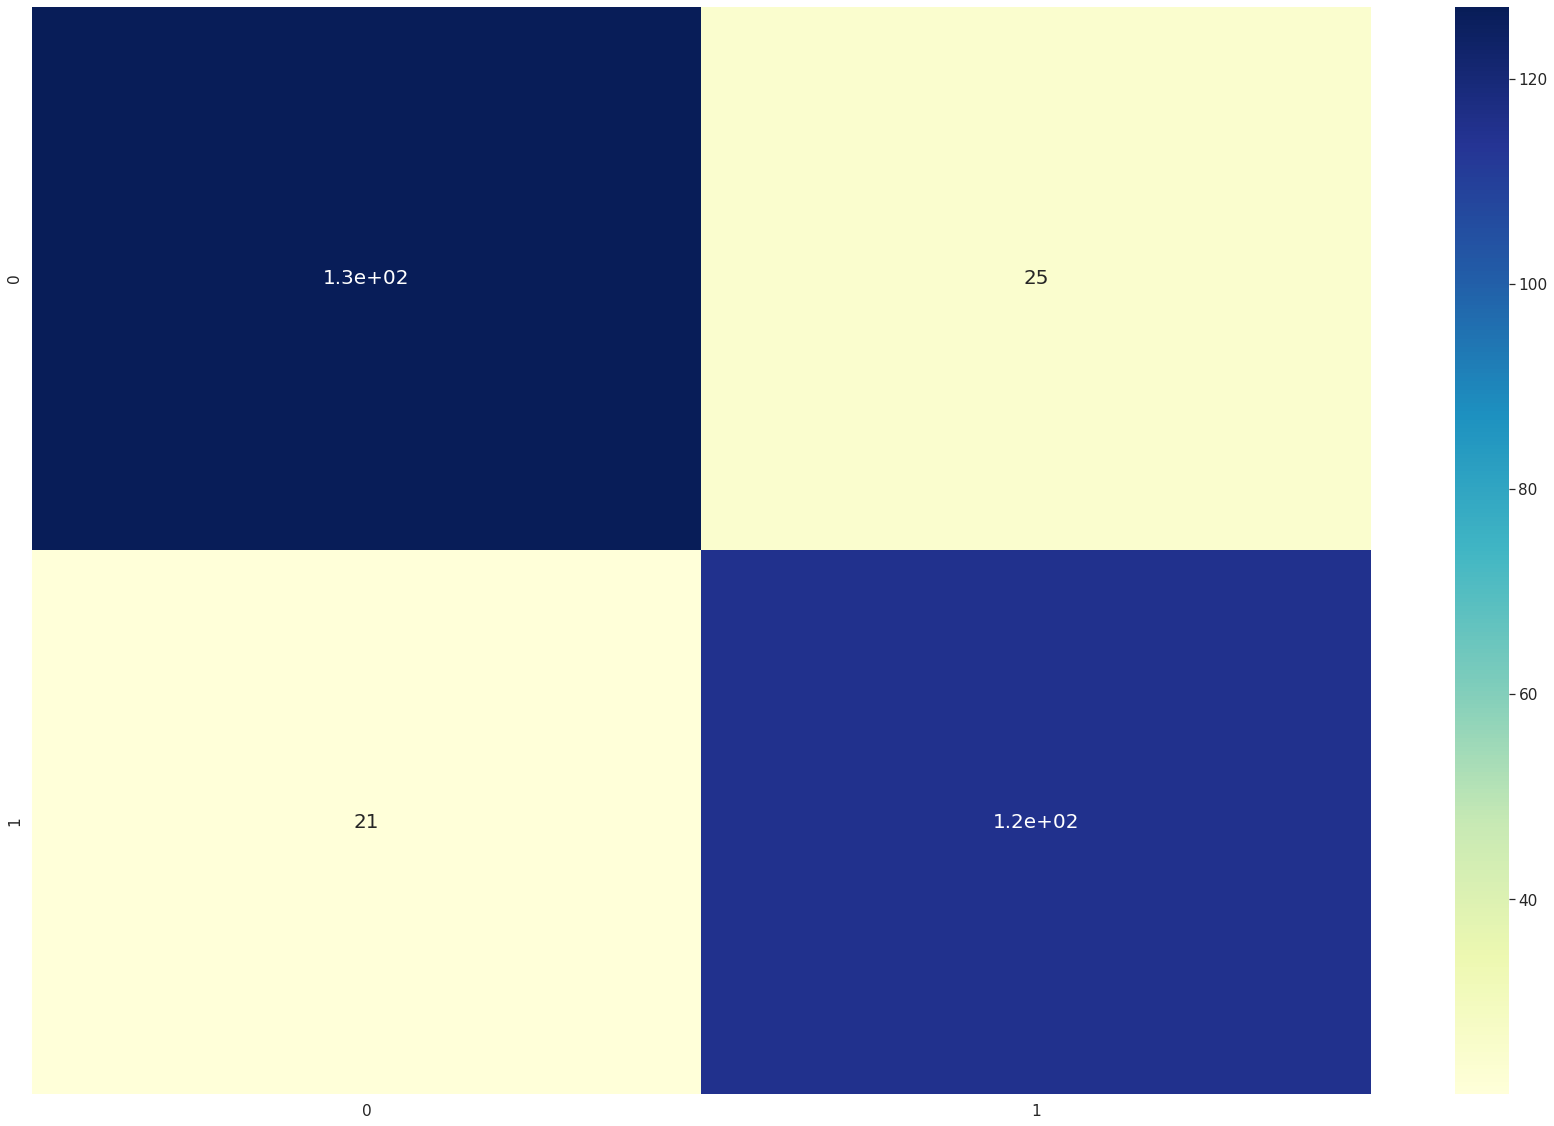

In [25]:
print('Confusion Matrix')
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import seaborn as sn
cm = confusion_matrix( pred ,valid_image_labels)
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 20},cmap="YlGnBu") # font size
plt.show()

In [37]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            recall = cf[1,1] / sum(cf[:,1])
            precision    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sn.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

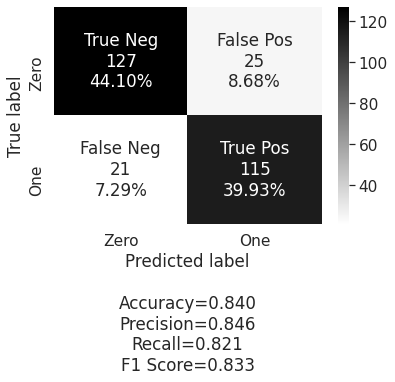

In [38]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cm, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')


### Kappa score

In [26]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
cohen_kappa_score(valid_image_labels, pred)

0.6800618238021638

### Classification report

In [33]:
print()
print('Classification Report')
print(classification_report(valid_image_labels, pred, target_names=["0","1"]))


Classification Report
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       148
           1       0.85      0.82      0.83       140

    accuracy                           0.84       288
   macro avg       0.84      0.84      0.84       288
weighted avg       0.84      0.84      0.84       288



### ROC score

In [34]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(valid_image_labels, pred_batch)

In [35]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

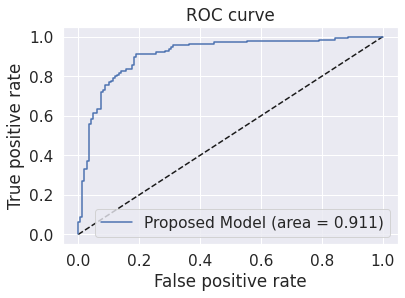

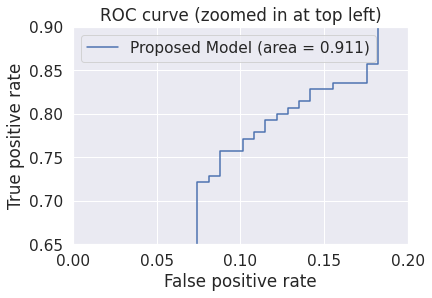

In [36]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Proposed Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0.0, 0.2)
plt.ylim(0.65, 0.9)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Proposed Model (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()